In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
img = cv2.imread('./imgs/fundus.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

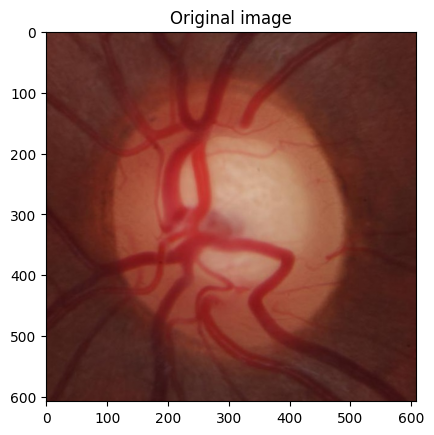

In [4]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original image')
plt.show()

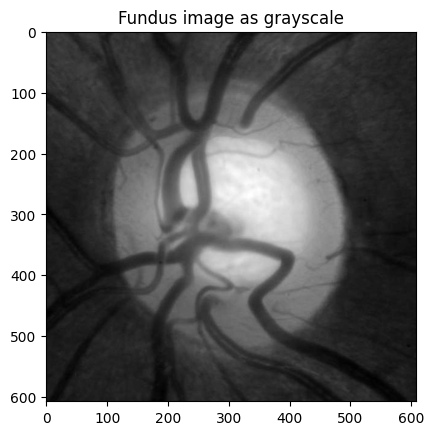

In [5]:
plt.imshow(gray, cmap='gray')
plt.title('Fundus image as grayscale')
plt.show()

### Thresholding

#### Simple

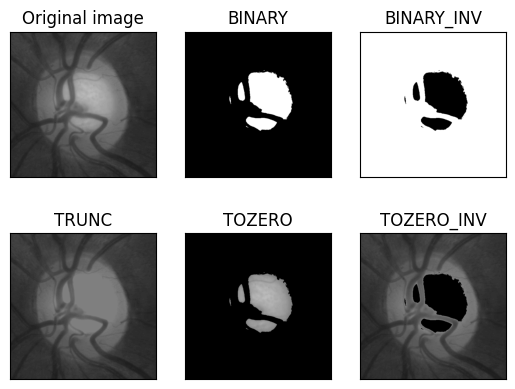

In [6]:
import cv2 as cv
ret, thresh1 = cv.threshold(gray, 127, 255, cv.THRESH_BINARY)
ret, thresh2 = cv.threshold(gray, 127, 255, cv.THRESH_BINARY_INV)
ret, thresh3 = cv.threshold(gray, 127, 255, cv.THRESH_TRUNC)
ret, thresh4 = cv.threshold(gray, 127, 255, cv.THRESH_TOZERO)
ret, thresh5 = cv.threshold(gray, 127, 255, cv.THRESH_TOZERO_INV)

titles = ['Original image', 'BINARY', 'BINARY_INV', 'TRUNC', 'TOZERO', 'TOZERO_INV']
images = [gray, thresh1, thresh2, thresh3, thresh4, thresh5]

for i in range(6):
    plt.subplot(2, 3, i+1),plt.imshow(images[i], 'gray', vmin=0, vmax=255)
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

plt.show()

#### Adaptive

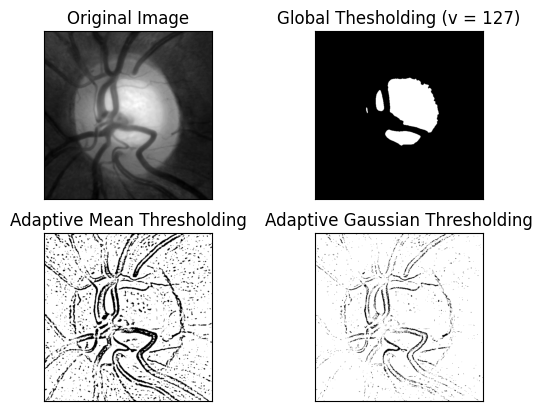

In [7]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

img = cv.imread('./imgs/fundus.png', cv.IMREAD_GRAYSCALE)
img = cv.medianBlur(img, 5)

ret, th1 = cv.threshold(img,127,255,cv.THRESH_BINARY)
th2 = cv.adaptiveThreshold(img, 255, cv.ADAPTIVE_THRESH_MEAN_C, \
                           cv.THRESH_BINARY, 11, 2)
th3 = cv.adaptiveThreshold(img, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, \
                           cv.THRESH_BINARY, 11, 2)

titles = ['Original Image', 'Global Thesholding (v = 127)', 'Adaptive Mean Thresholding','Adaptive Gaussian Thresholding']
images = [img, th1, th2, th3]

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(images[i], 'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

#### Otsu

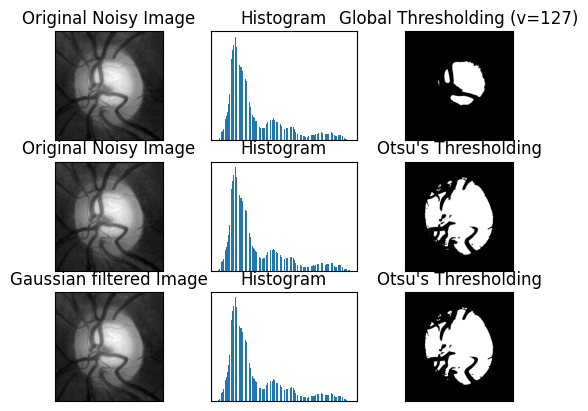

In [8]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

img = cv.imread('./imgs/fundus.png', cv.IMREAD_GRAYSCALE)

# global thresholding
ret1, th1 = cv.threshold(img, 127, 255, cv.THRESH_BINARY)

# Otsu thresholding
ret2, th2 = cv.threshold(img, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)

blur = cv.GaussianBlur(img, (5,5), 0)
ret3, th3 = cv.threshold(blur, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)

images = [img, 0, th1,
          img, 0, th2,
          img, 0, th3]

titles = ['Original Noisy Image','Histogram','Global Thresholding (v=127)',
          'Original Noisy Image','Histogram',"Otsu's Thresholding",
          'Gaussian filtered Image','Histogram',"Otsu's Thresholding"]

for i in range(3):
    plt.subplot(3,3,i*3+1),plt.imshow(images[i*3],'gray')
    plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+2),plt.hist(images[i*3].ravel(),256)
    plt.title(titles[i*3+1]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+3),plt.imshow(images[i*3+2],'gray')
    plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])
plt.show()

Looks like global thresholding segments the cup, and otsus segments the disc. Let's explore these two images with edge map and ellipse detector.

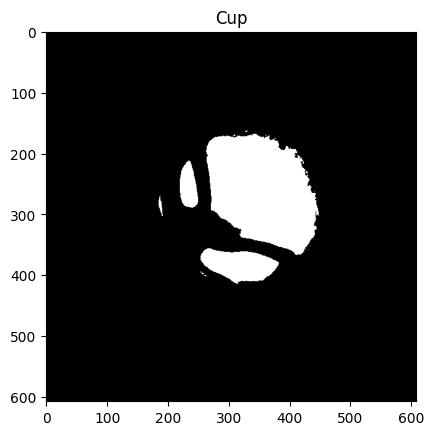

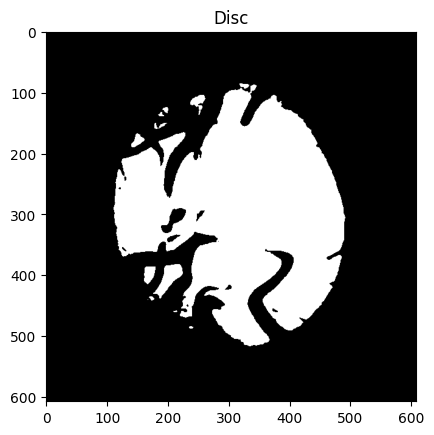

In [9]:
import cv2

cup = th1
disc = th3

plt.imshow(cup, cmap='gray')
plt.title('Cup')
plt.show()
plt.imshow(disc, 'gray')
plt.title('Disc')
plt.show()

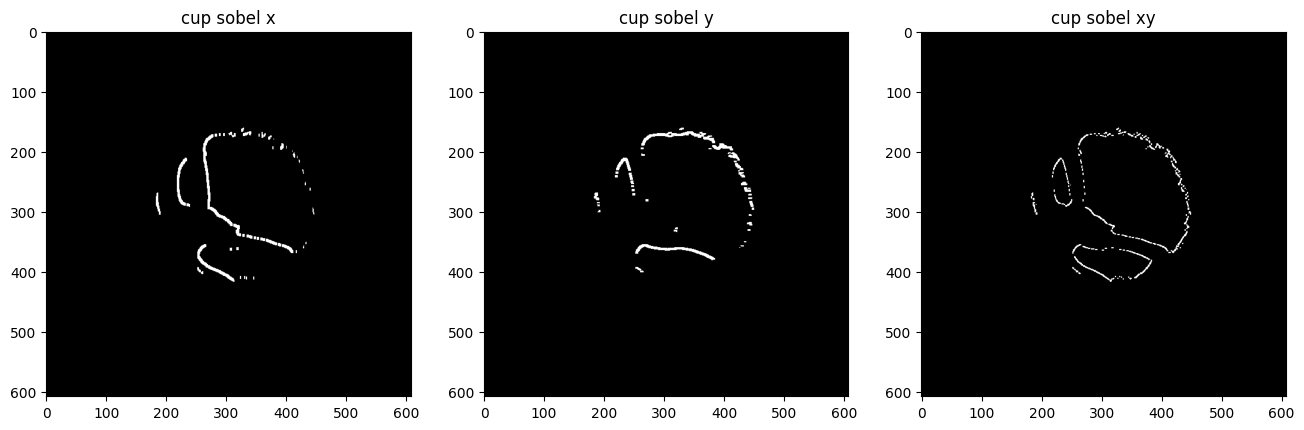

In [10]:
cup_sobelx = cv2.Sobel(src=cup, ddepth=cv2.CV_8U, dx=1, dy=0, ksize=5)
cup_sobely = cv2.Sobel(src=cup, ddepth=cv2.CV_8U, dx=0, dy=1, ksize=5)
cup_sobelxy = cv2.Sobel(src=cup, ddepth=cv2.CV_8U, dx=1, dy=1, ksize=5)

plt.figure(figsize=(16,16))
plt.subplot(1, 3, 1),plt.imshow(cup_sobelx, 'gray'),plt.title('cup sobel x')
plt.subplot(1, 3, 2),plt.imshow(cup_sobely, 'gray'),plt.title('cup sobel y')
plt.subplot(1, 3, 3),plt.imshow(cup_sobelxy, 'gray'),plt.title('cup sobel xy')
plt.show()

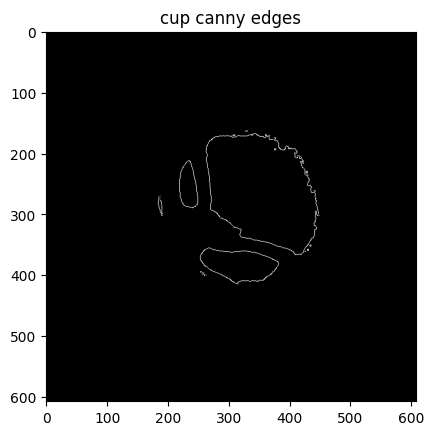

In [11]:
cup_edges = cv2.Canny(image=cup, threshold1=100, threshold2=200)

plt.imshow(cup_edges, 'gray')
plt.title('cup canny edges')
plt.show()

### OpenCV Hough Circles

In [12]:
rows = cup_edges.shape[0]
cup_circles = cv.HoughCircles(cup_edges, cv.HOUGH_GRADIENT, 1, rows / 8, param1=100, param2=30, minRadius=0, maxRadius=0)
cup_circles

array([[[332.5, 274.5, 102.7]]], dtype=float32)

In [13]:
detected_circle = cup_edges.copy()

if cup_circles is not None:
    cup_circles = np.uint16(np.around(cup_circles))
    for i in cup_circles[0, :]:
        center = (i[0], i[1])
        # circle center
        cv.circle(detected_circle, center, 1, (0, 100, 100), 3)
        # circle outline
        radius = i[2]
        cv.circle(detected_circle, center, radius, (255, 0, 255), 3)

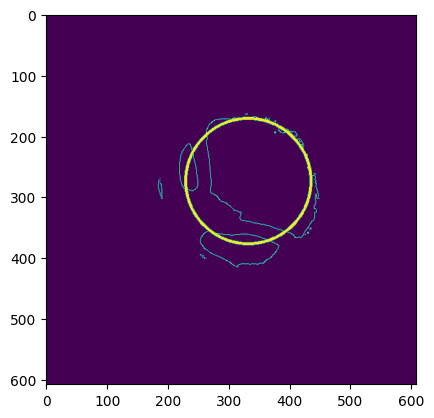

In [14]:
plt.imshow(detected_circle)
plt.show()

### OpenCV fitEllipse

In [15]:
import cv2

thresh = cup.copy()
contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

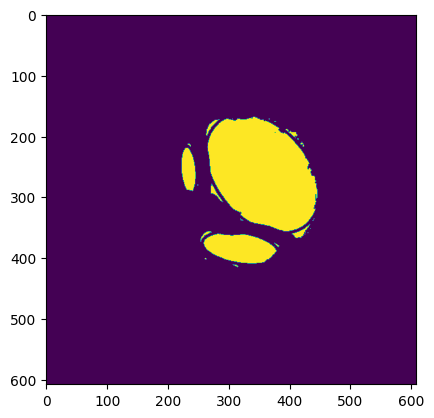

In [16]:
if len(contours) != 0:
    for i in range(len(contours)):
        if len(contours[i]) >= 5:
            ellipse = cv2.fitEllipse(contours[i])
            cv2.ellipse(thresh, ellipse, (0, 0, 255), 3)

plt.imshow(thresh)
plt.show()